In [48]:
import numpy as np
from astropy.io import fits
import os
import glob
import matplotlib.pylab as plt
%matplotlib inline
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from initial_wcss import wcs_zea_helper, wcs_azp_helper
from scipy.optimize import minimize

In [2]:
def chop_image(filename, x1,x2, y1, y2, outroot='chop_image_temp'):
    """
    Parameters
    ----------
    filename : str
        The fits file to try and chop up
    """
    in_image = fits.open(filename)
    #date = in_image[0].header['DATE-OBS']
    #image_time = Time(date, format='isot', scale='utc')
    for i in np.arange(np.size(y1)):
        outfile = outroot+'_%i' % i + '.fits'
        if os.path.exists(outfile):
            os.unlink(outfile)
        sub_image = in_image[0].data[y1[i]:y2[i], x1[i]:x2[i]]
        hdu = fits.PrimaryHDU(sub_image)
        hdu.writeto(outfile)


In [3]:
filename = '2019-09-04/2019_09_05__06_31_15.fits'
in_im = fits.open(filename)
image_time = Time(in_im[0].header['DATE-OBS'], format='isot', scale='utc')
in_im.close()

In [4]:
nx = 2448
ny = 2536

xmin = 250
xmax = 2328

ymin = 152
ymax = 2231

window = 300
ys = np.arange(ymin, ymax+window, window)
ys[np.where(ys > ymax)] = ymax

xs = np.arange(xmin, xmax+window, window)
xs[np.where(xs > xmax)] = xmax


In [5]:
# Probably a faster way to do this, but it's readable I guess
y1 = []
y2 = []
x1 = []
x2 = []

for indx_x, x in enumerate(xs[:-2]):
    for indx_y, y in enumerate(ys[:-2]):
        y1.append(y)
        y2.append(ys[indx_y+2])
        x1.append(x)
        x2.append(xs[indx_x+2])

In [6]:
xs, ys

(array([ 250,  550,  850, 1150, 1450, 1750, 2050, 2328]),
 array([ 152,  452,  752, 1052, 1352, 1652, 1952, 2231]))

In [7]:
chop_image(filename, x1, x2, y1, y2)

In [ ]:
# now to run astrometry.net on all the sub-sections
# ls *.fits | xargs -I'{}' solve-field --scale-units arcsecperpix --scale-low 150 --scale-high 300 –no-plots --overwrite '{}'

In [6]:
# Read in the solutions from astrometry.net
filelist = glob.glob('*.rdls')

In [7]:
def read_astromnet(fileroot, xadd=0, yadd=0):
    hdul = fits.open(fileroot+'-indx.xyls')
    xy = hdul[1].data.copy()
    hdul.close()
    
    hdul = fits.open(fileroot+'.rdls')
    radec = hdul[1].data.copy()
    hdul.close()
    
    names = ['x', 'y', 'RA', 'dec']
    types = [float]*4
    result = np.zeros(radec.size, dtype=list(zip(names,types)))
    result['x'] = xy['X'] + xadd
    result['y'] = xy['Y'] + yadd
    result['RA'] = radec['RA']
    result['dec'] = radec['DEC']
    return result

In [120]:
points = []
for filename in filelist:
    indx = int(filename.split('_')[-1][:-5])
    data = read_astromnet(filename[:-5], xadd=x1[indx], yadd=y1[indx])
    points.append(data)
points = np.concatenate(points)

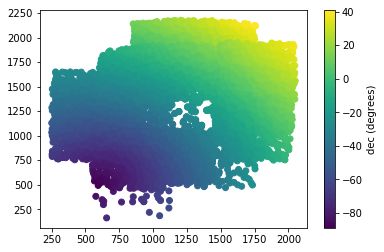

In [121]:
plt.scatter(points['x'], points['y'], c=points['dec'])
cb = plt.colorbar()
cb.set_label('dec (degrees)')

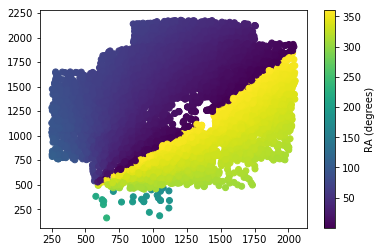

In [122]:
plt.scatter(points['x'], points['y'], c=points['RA'])
cb = plt.colorbar()
cb.set_label('RA (degrees)')

In [123]:
# Now we can convert this to alt,az
default_location = EarthLocation(lat=-30.2444*u.degree, lon=-70.7494*u.degree,
                                 height=2650.0*u.meter)
coords = SkyCoord(ra=points['RA']*u.degree, dec=points['dec']*u.degree)
temp = coords.transform_to(AltAz(obstime=image_time, location=default_location))
alt = temp.alt.value
az = temp.az.value

# Let's crop off th ereally low ones for now
#good = np.where((points['x'] > 1500) & (points['x'] < 1700) & (points['y'] > 1500) & (points['y'] < 1750))[0]
#alt = alt[good]
#az = az[good]
#points = points[good]

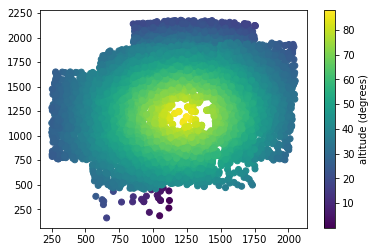

In [124]:
plt.scatter(points['x'], points['y'], c=alt)
cb = plt.colorbar()
cb.set_label('altitude (degrees)')

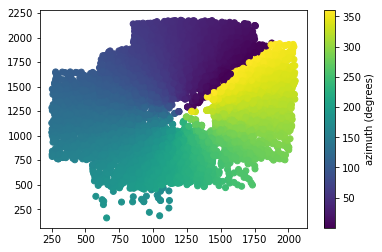

In [125]:
plt.scatter(points['x'], points['y'], c=az)
cb = plt.colorbar()
cb.set_label('azimuth (degrees)')

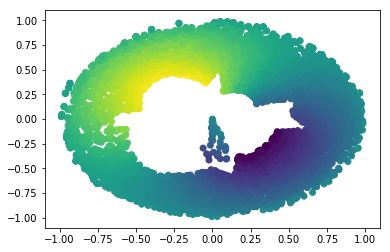

In [134]:
r = np.sin(np.radians(alt))
plt.scatter(r*np.sin(np.radians(az)), r*np.cos(np.radians(az)), c=points['x'])

In [126]:
## OK, now we have a great set of points looks like zenith is around 1250,1250. We can fit a first pass WCS that 
# maps pixels to Alt,Az. 

In [127]:
fun = wcs_zea_helper(points['x'], points['y'], alt, az, crpix1=1250, crpix2=1250)

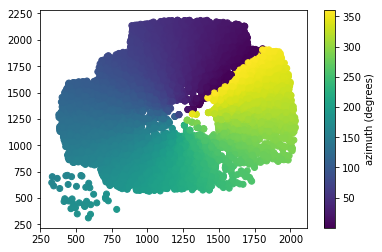

In [128]:
# Let's manually construct a decent looking WCS
x0 = np.array([1250,  1250,  0.07, 0.07, .76, -.64,  .64,   0.76 ])
#fit_result = minimize(fun, x0)
wcs_out = fun.return_wcs(x0)
x_out, y_out = wcs_out.all_world2pix(az, alt, 0)
plt.scatter(x_out, y_out, c=az)
cb = plt.colorbar()
cb.set_label('azimuth (degrees)')

In [129]:
fit_result = minimize(fun, x0)
fit_result

      fun: 2385.358872492271
 hess_inv: array([[ 9.99894342e-01, -1.04173997e-04,  5.32955037e-04,
        -5.51029809e-10, -9.98723137e-04, -7.49591449e-03,
         5.06583622e-03,  7.58349558e-03],
       [-1.04173997e-04,  1.00017461e+00,  1.20198779e-03,
        -8.52055569e-10, -5.49159528e-03,  2.84410242e-03,
         3.26656792e-03,  1.77484075e-03],
       [ 5.32955037e-04,  1.20198779e-03,  4.06571210e-02,
        -3.81439104e-09, -1.57910748e-01,  1.23558492e-01,
         8.50046518e-02, -3.48969148e-02],
       [-5.51029809e-10, -8.52055569e-10, -3.81439104e-09,
         3.39858437e-14,  1.48152887e-08, -1.15865470e-08,
        -7.97770959e-09,  3.26735226e-09],
       [-9.98723137e-04, -5.49159528e-03, -1.57910748e-01,
         1.48152887e-08,  6.13321452e-01, -4.79904921e-01,
        -3.30151512e-01,  1.35543953e-01],
       [-7.49591449e-03,  2.84410242e-03,  1.23558492e-01,
        -1.15865470e-08, -4.79904921e-01,  3.75591380e-01,
         2.58292820e-01, -1.06134930e

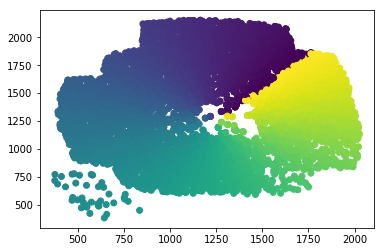

In [130]:
wcs_out = fun.return_wcs(fit_result.x)
x_out, y_out = wcs_out.all_world2pix(az, alt, 0)
plt.scatter(x_out, y_out, c=az)

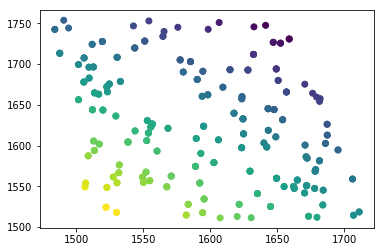

In [102]:
plt.scatter(x_out, y_out, c=alt)

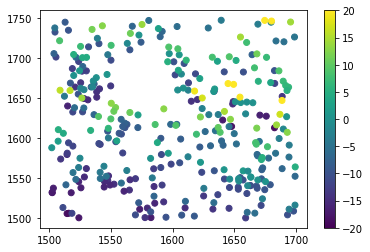

In [107]:
plt.scatter(points['x'], points['y'], c=points['y']-y_out, vmin=-20, vmax=20)
plt.colorbar()

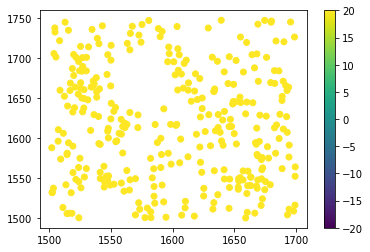

In [111]:
plt.scatter(points['x'], points['y'], c=alt, vmin=-20, vmax=20)
plt.colorbar()

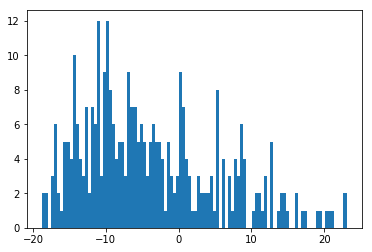

In [108]:
ack = plt.hist(points['y'] - y_out, 100)

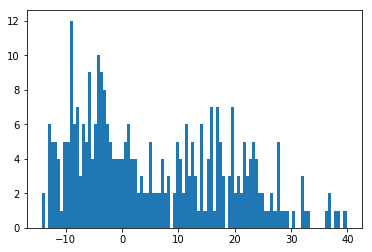

In [109]:
ack = plt.hist(points['x'] - x_out, 100)

In [115]:
order = np.argsort(alt)
points['x'][order][0:10]


array([1679.67732371, 1695.48240707, 1698.69260192, 1669.00357016,
       1690.11314137, 1680.06092131, 1683.67482276, 1674.51595825,
       1639.26705786, 1628.77374061])

In [116]:
alt[order][0:10]

array([39.81963138, 40.05918066, 40.05918066, 40.3803663 , 40.73481611,
       40.73481611, 40.94279541, 40.94279541, 41.2696196 , 42.23669415])

In [118]:
az[order][0:10]

array([3.21882101, 1.36399685, 1.36399685, 3.65579698, 1.48905746,
       1.48905746, 1.86598644, 1.86598644, 5.52172813, 5.66517473])

In [119]:
points['y'][order][0:10]

array([1745.01419941, 1745.28065664, 1726.51436843, 1742.55697655,
       1720.51871822, 1746.49008267, 1721.57711958, 1747.28544161,
       1747.46518488, 1737.80610113])